In [127]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [128]:
df = pd.read_csv('TEST TASK (dataset).csv')# read_data

## Decision Tree

Нижче ми трішки підшаманюємо в даних. Додаємо коолонки, які нам будуть в подальшому потрібно. Заповнюємо нани. Розділяємо на train та test

In [129]:
# target_pay - if person give us money than we mark him as "1"
df['target_pay'] = df['target_full_ltv_day30'].apply(lambda x: 0 if x==0 else 1)

dont_need_cols = ['target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30',
       'target_full_ltv_day30','target_pay']
need_cols = []
for i in df.columns:
    if i not in dont_need_cols:
        need_cols.append(i)

X = df[need_cols]
y = df[['target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30',
       'target_full_ltv_day30','target_pay']]

# fill missing data

# choose categorical and continuous features from data

categorical_columns = [
    c for c in X.columns if X[c].dtype.name == "object"
]
numerical_columns = [
    c for c in X.columns if X[c].dtype.name != "object"
]

print("categorical_columns:", categorical_columns)
print("numerical_columns:", numerical_columns)

for c in categorical_columns:
    X[c].fillna(X[c].mode()[0], inplace=True)
    X[c].fillna(X[c].mode()[0], inplace=True)

for c in numerical_columns:
    X[c].fillna(X[c].median(), inplace=True)
    X[c].fillna(X[c].median(), inplace=True)

X = pd.concat(
    [X[numerical_columns], pd.get_dummies(X[categorical_columns])],
    axis=1,
)

from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X,y,random_state = 17,test_size = 0.3)


categorical_columns: ['media_source', 'install_date', 'country_code', 'platform']
numerical_columns: ['total_sessions_day0', 'total_sessions_day1', 'total_sessions_day3', 'total_sessions_day7', 'chapters_finished_day0', 'chapters_finished_day1', 'chapters_finished_day3', 'chapters_finished_day7', 'chapters_opened_day0', 'chapters_opened_day1', 'chapters_opened_day3', 'chapters_opened_day7', 'chapters_closed_day0', 'chapters_closed_day1', 'chapters_closed_day3', 'chapters_closed_day7', 'diamonds_received_day0', 'diamonds_received_day1', 'diamonds_received_day3', 'diamonds_received_day7', 'diamonds_spent_day0', 'diamonds_spent_day1', 'diamonds_spent_day3', 'diamonds_spent_day7', 'tickets_spent_day0', 'tickets_spent_day1', 'tickets_spent_day3', 'tickets_spent_day7', 'retained_day1', 'retained_day3', 'retained_day7', 'chapters_finished_session1', 'chapters_finished_session3', 'chapters_finished_session9', 'chapters_opened_session1', 'chapters_opened_session3', 'chapters_opened_session9', '

Нижче ми спробували DecisionTreeRegressor. За допомогою цього ми дізнались, які колонки Дерево вирішить будуть важливими. Результат можна побачити в файлі desicion_trees/target_full_decision_teree.png

In [130]:
## DecisionTreeRegressor - предіктить значення 

tree_params = {"max_depth": [7]}
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
locally_best_tree = GridSearchCV(
    DecisionTreeRegressor(random_state=17), tree_params, cv=5
)

locally_best_tree.fit(X_train, y_train['target_full_ltv_day30'])


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=17),
             param_grid={'max_depth': [7]})

# Найкращі фічі вибрані деревом

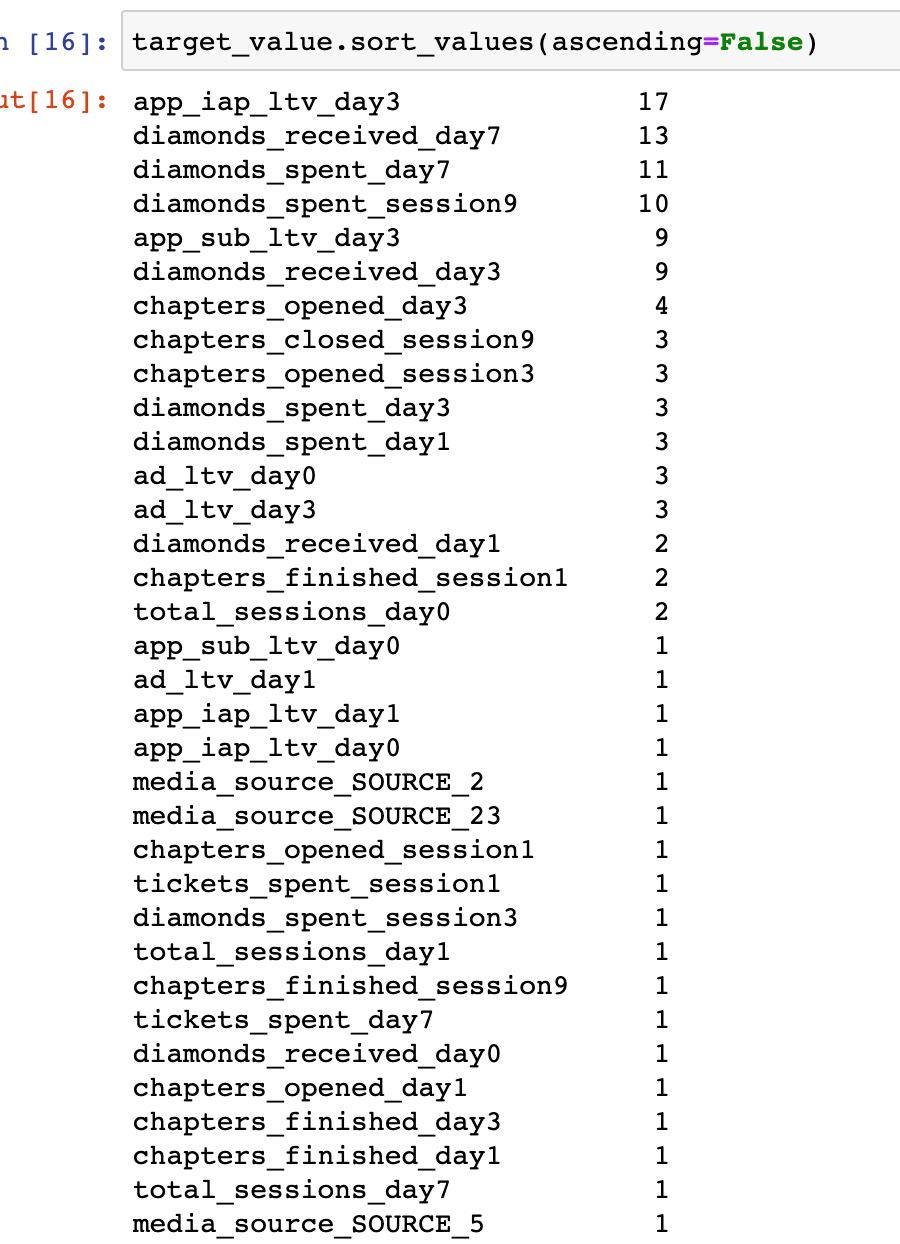

Нижче  буде написаний код, який нам власне створив те png (закоментований). Запускати особливо небезпечно

In [131]:
# show decision tree in png
biba = locally_best_tree.best_estimator_

y_pred = biba.predict(X_test)

# import pydotplus  # pip install pydotplus
# from sklearn.tree import export_graphviz


# def tree_graph_to_png(tree, feature_names, png_file_to_save):
#     tree_str = export_graphviz(
#         tree, feature_names=feature_names, filled=True, out_file=None
#     )
#     graph = pydotplus.graph_from_dot_data(tree_str)
#     graph.write_png(png_file_to_save)
# tree_graph_to_png(
#     tree=biba,
#     feature_names=X.columns,
#     png_file_to_save="topic3_decision_tree1.png",
# )
# #show decision tree in png
# tree_str = export_graphviz(
#         biba, feature_names=X.columns, filled=True, out_file=None
#     )
# f= open('target_value_best_tree.txt','w')
# f.write(tree_str)
# f.close()

# Decision Tree metrics

перевіряємо метрики DecisionTree

In [132]:
unique, counts = np.unique(y_pred, return_counts=True)

unique.min()

0.012328567731347606

In [136]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def MAPE(Y_actual,Y_Predicted):
    Y_actual, Y_Predicted = np.array(Y_actual), np.array(Y_Predicted)
    mape = np.mean(np.abs(Y_actual - Y_Predicted)/Y_actual)*100
    return mape

print('before: '\
      ,r2_score(y_test['target_full_ltv_day30'], y_pred)\
      , mean_absolute_error(y_test['target_full_ltv_day30'], y_pred)\
      , np.sqrt(mean_squared_error(y_test['target_full_ltv_day30'], y_pred))
      ,MAPE(y_test['target_full_ltv_day30'], y_pred))

before:  0.6927063457837009 0.1112042751553232 1.3238912789252346 inf


# Can we get lesser result

Ми маємо дуже багато зароблених коштів 0лів. А в дереві рішень у нас найменше значення саме 0. Змінимо 0.0012 на 0 та подивимось на результати

In [137]:
y_pred2 = y_pred.copy()
value = y_pred2[0]
for i in range(len(y_pred2)):
    if y_pred2[i]==value:
        y_pred2[i]=0
unique, counts = np.unique(y_pred2, return_counts=True)
unique.min()


0.0

In [139]:
print('after: '\
      ,r2_score(y_test['target_full_ltv_day30'], y_pred)\
      , mean_absolute_error(y_test['target_full_ltv_day30'], y_pred)\
      , np.sqrt(mean_squared_error(y_test['target_full_ltv_day30'], y_pred))
      ,MAPE(y_test['target_full_ltv_day30'], y_pred))

after:  0.6927063457837009 0.1112042751553232 1.3238912789252346 inf


Краще не стало. То ж перейдемо до іншого варіанту

# Tree predict is paying

Оскільки в якийсь момент ми згадали, що у нас 76 відсоктів 0лів. До нас прийшла геніальна ідея спробувати спочатку предіктити чи платив клієнт нам чи ні.  Для цього ми обрали дерево рішень та логістичну регресію. Дерево рішень показало кращі результати) 

In [140]:
# predict 0 or 1


tree_params = {"max_depth": [16]}
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
locally_best_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=17), tree_params, cv=5
)

locally_best_tree.fit(X_train, y_train['target_pay'])
biba2  = locally_best_tree.best_estimator_

y_pred_train = biba2.predict(X_train)

# show decision tree in png

In [141]:
from sklearn.metrics import precision_score,recall_score
accuracy_score(y_test['target_pay'],y_pred_target_pay)\
,precision_score(y_test['target_pay'],y_pred_target_pay,pos_label=1)\
,precision_score(y_test['target_pay'],y_pred_target_pay,pos_label=0)\
,recall_score(y_test['target_pay'],y_pred_target_pay,pos_label=1)\
,recall_score(y_test['target_pay'],y_pred_target_pay,pos_label=0)

(0.9933484728057227,
 0.9871843749083551,
 0.9952137682552736,
 0.9842306342832638,
 0.99611838482173)

#### Результати логістичної регресії


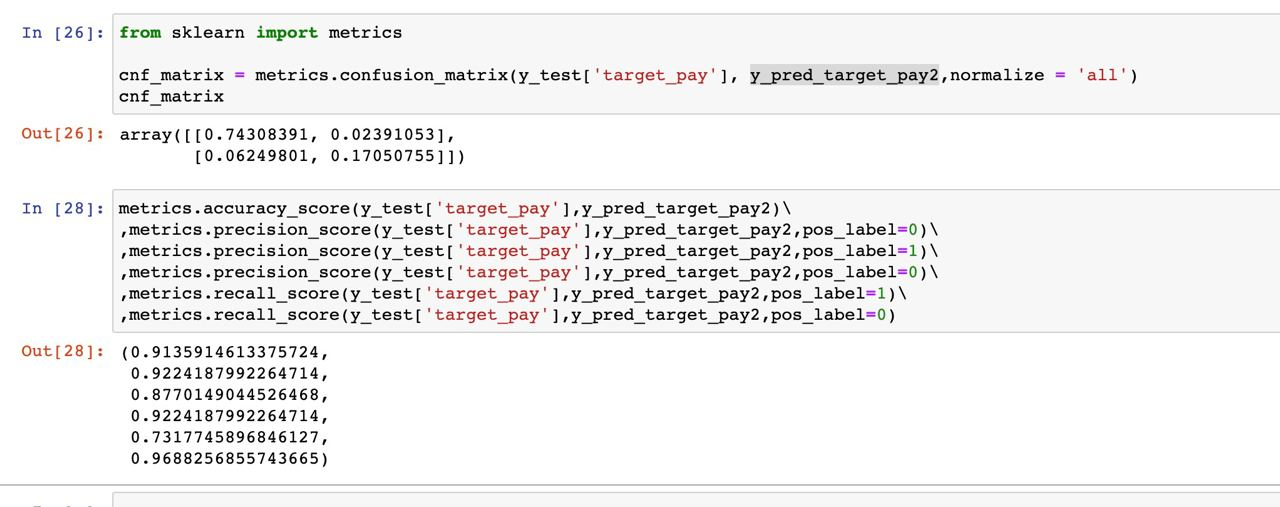

Тепер предікт даних у нас буде в два етапи. Спочатку предіктимо чи заплатить наш клієнт чи ні, а потім уже предіктимо окремо скільки заплатять ті, кого ми запредіктили , як ті , що платять.

In [142]:
y_train_target = y_train['target_full_ltv_day30']

X_train_1 = X_train[y_pred_train ==1]

from sklearn.linear_model import LinearRegression

logreg = LinearRegression()

logreg.fit(X_train_1, y_train_target[y_pred_train ==1])

# select 0s
y_pred_target_pay = biba2.predict(X_test)
X_test_1 = X_test[y_pred_target_pay==1]
Y_test_1 = y_test[y_pred_target_pay==1]['target_full_ltv_day30']

# select 1s
X_test_0 = X_test[y_pred_target_pay==0]
Y_test_0 = y_test[y_pred_target_pay==0]['target_full_ltv_day30']



In [143]:
Y_pred_on_1 = logreg.predict(X_test_1)

In [144]:
a = pd.Series(Y_test_0)
b = pd.Series(Y_test_1)
result = pd.concat([a,b])

pred_0 = pd.Series(np.full(len(Y_test_0), 0))
pred_1 = pd.Series(Y_pred_on_1)
result_pred = pd.concat([pred_0,pred_1])



from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def MAPE(Y_actual,Y_Predicted):
    Y_actual, Y_Predicted = np.array(Y_actual), np.array(Y_Predicted)
    mape = np.mean(np.abs(Y_actual - Y_Predicted)/Y_actual)*100
    return mape

#y_test_on_1 = y_test[y_pred_train ==1]['target_full_ltv_day30']
print('before: '\
      , r2_score(result, result_pred)\
      , mean_absolute_error(result, result_pred)\
      , np.sqrt(mean_squared_error(result, result_pred))
      , MAPE(result,result_pred))

before:  0.7740152550913799 0.11670043041897112 1.135311630340269 nan


Результати стали доволі кращими. Але не набагато.

# Lets log some numerical variables and use only them

In [145]:
X_train_1_numerical = X_train_1[numerical_columns]
X_train_1_numerical


for i in X_train_1_numerical.columns:
    X_train_1_numerical[i] = np.log(X_train_1_numerical[i]+1)
X_train_1_numerical

,total_sessions_day0,total_sessions_day1,total_sessions_day3,total_sessions_day7,chapters_finished_day0,chapters_finished_day1,chapters_finished_day3,chapters_finished_day7,chapters_opened_day0,chapters_opened_day1,...,tickets_spent_session9,app_sub_ltv_day0,app_sub_ltv_day1,app_sub_ltv_day3,app_iap_ltv_day0,app_iap_ltv_day1,app_iap_ltv_day3,ad_ltv_day0,ad_ltv_day1,ad_ltv_day3
671560,1.386294,2.197225,2.564949,2.772589,1.791759,2.944439,3.610918,3.637586,1.791759,2.944439,...,2.564949,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.028898,0.033754,0.034837
1284989,0.693147,0.693147,0.693147,0.693147,1.098612,1.098612,1.098612,1.098612,1.609438,1.609438,...,1.098612,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000708,0.000708,0.000708
619348,0.693147,0.693147,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612,...,0.693147,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.007718,0.007718,0.007718
1359495,1.386294,1.386294,1.386294,1.386294,0.693147,0.693147,0.693147,0.693147,1.791759,1.791759,...,0.693147,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.001070,0.001070,0.001070
506303,0.693147,0.693147,1.098612,1.098612,1.791759,1.791759,1.945910,1.945910,1.945910,1.945910,...,1.791759,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.053647,0.053647,0.058241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321566,2.397895,2.890372,3.091042,3.433987,2.079442,2.564949,2.639057,2.772589,2.302585,2.833213,...,1.945910,0.0,0.0,0.0,1.643589,1.643589,1.643589,0.172081,0.200705,0.218292
1135289,1.609438,1.609438,1.609438,1.609438,1.609438,1.609438,1.609438,1.609438,1.945910,1.945910,...,1.098612,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.084281,0.084281,0.084281
261137,3.258097,3.526361,3.526361,3.526361,0.693147,1.098612,1.098612,1.098612,1.098612,1.386294,...,0.693147,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.212760,0.212760,0.212760
287775,1.386294,1.386294,1.386294,1.386294,1.609438,1.609438,1.609438,1.609438,1.945910,1.945910,...,1.386294,0.0,0.0,0.0,1.763893,1.763893,1.763893,0.115851,0.115851,0.115851


In [146]:
y_train_target = y_train['target_full_ltv_day30']

# X_train_1 = X_train[y_pred_train ==1]

X_test_1_numerical = X_test_1[numerical_columns]
for i in X_test_1_numerical.columns:
    X_test_1_numerical[i] = np.log(X_test_1_numerical[i]+1)
    

for c in X_train_1_numerical.columns:
    
    X_train_1_numerical[c].fillna(X_train_1_numerical[c].median(), inplace=True)
    
    X_test_1_numerical[c].fillna(X_test_1_numerical[c].median(), inplace=True)

from sklearn.linear_model import LinearRegression
Y_train_1_target = y_train_target[y_pred_train ==1]

logreg2 = LinearRegression()

logreg2.fit(X_train_1_numerical, Y_train_1_target)


Y_target_1_pred2 = logreg2.predict(X_test_1_numerical)


In [152]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def MAPE(Y_actual,Y_Predicted):
    Y_actual, Y_Predicted = np.array(Y_actual), np.array(Y_Predicted)
    mape = np.mean(np.abs(Y_actual - Y_Predicted)/Y_actual)*100
    return mape



pred_0_2 = pd.Series(np.full(len(Y_test_0), 0))
pred_1_2 = pd.Series(Y_target_1_pred2)
result_pred_2 = pd.concat([pred_0_2,pred_1_2])

#y_test_on_1 = y_test[y_pred_train ==1]['target_full_ltv_day30']
print('before: '\
      , r2_score(result, result_pred_2)\
      , mean_absolute_error(result, result_pred_2)\
      , np.sqrt(mean_squared_error(result, result_pred_2))
      , MAPE(result,result_pred_2))

before:  0.4707651497441293 0.24792817754305085 1.7373997022498762 nan


Як ми бачимо нажаль, у нас стало все набагато гірше.

# Lets log some numerical variables and use with categorical

Спробуємо взяти також і категоріальні змінні

In [154]:
X_train_log = X_train_1.copy()
X_test_log = X_test_1.copy()

In [156]:

for i in numerical_columns:
    X_train_log[i] = np.log(X_train_log[i]+1)
    X_test_log[i] = np.log(X_test_log[i]+1)


y_train_target = y_train['target_full_ltv_day30']

# X_train_1 = X_train[y_pred_train ==1]

for c in numerical_columns:
    
    X_train_log[c].fillna(X_train_log[c].median(), inplace=True)
    
    X_test_log[c].fillna(X_test_log[c].median(), inplace=True)

from sklearn.linear_model import LinearRegression
Y_train_1_target = y_train_target[y_pred_train ==1]

logreg3 = LinearRegression()

logreg3.fit(X_train_log, Y_train_1_target)


Y_target_1_pred3 = logreg3.predict(X_test_log)


In [157]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def MAPE(Y_actual,Y_Predicted):
    Y_actual, Y_Predicted = np.array(Y_actual), np.array(Y_Predicted)
    mape = np.mean(np.abs(Y_actual - Y_Predicted)/Y_actual)*100
    return mape



pred_0_3 = pd.Series(np.full(len(Y_test_0), 0))
pred_1_3 = pd.Series(Y_target_1_pred3)
result_pred_3 = pd.concat([pred_0_3,pred_1_3])

#y_test_on_1 = y_test[y_pred_train ==1]['target_full_ltv_day30']
print('before: '\
      , r2_score(result, result_pred_3)\
      , mean_absolute_error(result, result_pred_3)\
      , np.sqrt(mean_squared_error(result, result_pred_3))
      , MAPE(result,result_pred_3))

before:  -386989464288723.06 76569.66816677367 46981307.17509206 nan


# Comulative

Комулятивний LTV має вигляд графіку логарифму.
 Робимо предікт на np.polyfit() цих трьох значень та логарифмів днів (np.log(1),np.log(2),np.log(4)) та значень 'app_sub_ltv_day0', 'app_sub_ltv_day1','app_sub_ltv_day3'. Потім отримані коефіцієнти множимо на 31. І отримаємо потрібні результати для предіктингу

In [229]:
#for i in X_test_1.index:

k = np.log(31)
predi = [np.log(1),np.log(2),np.log(4)]
l = []
m = []
for i in range(len(X_test_1.index)):
    
    # #Shadow Fiend
    z = np.polyfit(x = predi
               ,y = list (X_test_1.iloc[i][['app_sub_ltv_day0', 'app_sub_ltv_day1','app_sub_ltv_day3']])
               ,deg = 1)
    x = np.polyfit(x = predi
               ,y = list (X_test_1.iloc[i][['app_iap_ltv_day0', 'app_iap_ltv_day1','app_iap_ltv_day3']])
               ,deg = 1)
    c = np.polyfit(x = predi
               ,y = list (X_test_1.iloc[i][['ad_ltv_day0', 'ad_ltv_day1', 'ad_ltv_day3']])
               ,deg = 1)
    
    su =z[1]+x[1]+c[1]+(z[0]+x[0]+c[0])*k
    l.append(su)
    
    day_0 = X_test_1.iloc[i]['app_sub_ltv_day0']+X_test_1.iloc[i]['app_iap_ltv_day0']+X_test_1.iloc[i]['ad_ltv_day0']
    day_1 = X_test_1.iloc[i]['app_sub_ltv_day1']+X_test_1.iloc[i]['app_iap_ltv_day1']+X_test_1.iloc[i]['ad_ltv_day1']
    day_3 = X_test_1.iloc[i]['app_sub_ltv_day3']+X_test_1.iloc[i]['app_iap_ltv_day3']+X_test_1.iloc[i]['ad_ltv_day3']
    v = np.polyfit(x = predi,y = [day_0,day_1,day_3],deg = 1)
    bu = v[1]+v[0]*k
    m.append(bu)

pred_0_4 = pd.Series(np.full(len(Y_test_0), 0))
pred_1_4 = pd.Series(l)
result_pred_4 = pd.concat([pred_0_4,pred_1_4])

#y_test_on_1 = y_test[y_pred_train ==1]['target_full_ltv_day30']
print('predict 3 target valeus: '\
      , r2_score(result, result_pred_4)\
      , mean_absolute_error(result, result_pred_4)\
      , np.sqrt(mean_squared_error(result, result_pred_4))
      , MAPE(result,result_pred_4))

pred_0_5 = pd.Series(np.full(len(Y_test_0), 0))
pred_1_5 = pd.Series(m)
result_pred_5 = pd.concat([pred_0_5,pred_1_5])

#y_test_on_1 = y_test[y_pred_train ==1]['target_full_ltv_day30']
print('predict on target: '\
      , r2_score(result, result_pred_5)\
      , mean_absolute_error(result, result_pred_5)\
      , np.sqrt(mean_squared_error(result, result_pred_5))
      , MAPE(result,result_pred_5))

predict 3 target valeus:  0.5976249965058007 0.1169605449799809 1.5149246144442878 nan
predict on target:  0.5976249965058007 0.1169605449799809 1.5149246144442878 nan


То ж фінально: найкраща модель, що у нас вийшла: спочатку предікт 0ликів за допомогою дерева рішень, а потім уже логарифмічна регресія, де ми предіктили заробіток одиничок

In [ ]:
Дивно , що це з`являється лиш тут, але ми спробували регресію лінійну на всіх елементах з X_train

In [242]:
logreg4 = LinearRegression()

logreg4.fit(X_train, y_train['target_full_ltv_day30'])



Y_pred_all_test = logreg4.predict(X_test)

print('predict on all train data: '\
      , r2_score(y_test['target_full_ltv_day30'], Y_pred_all_test)\
      , mean_absolute_error(y_test['target_full_ltv_day30'], Y_pred_all_test)\
      , np.sqrt(mean_squared_error(y_test['target_full_ltv_day30'], Y_pred_all_test))
      , MAPE(y_test['target_full_ltv_day30'],Y_pred_all_test))

predict on all train data:  0.7721455108499499 0.13454073035967365 1.1399986053122164 inf


Порівнюючи з нашою найкращою моделлю ця хоч і приблизилась, проте все ще не може її перемогти по жодному з параметрів. Тому офіційним переможцем можна назвати модель, де спочатку йде дерево рішень. Після дерева рішень ми на тих елементах, де ми запредіктили платівника предіктимо його платіж за допомогою Лінійної регресії


P.S.

Варіанти для покращення моделей:
1. Погратись з random_state. Наче скрізь ми робили його однаковим, а саме =17.
2. Зменщувати кількість фіч під час предікту лінійною регресію по всім параметрам. Наприклад брати лише ті, які нам сказало дерево рішень (регресор).
3. Спробувати дерево рішень(регресор) на тих, хто повинен платити